<a href="https://colab.research.google.com/github/fourmodern/toc_tutorial_colab/blob/main/teachopencadd/t010_talktorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T010 · Binding site similarity and off-target prediction

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Angelika Szengel, CADD seminar 2017, Charité/FU Berlin
- Marvis Sydow, CADD seminar 2018, Charité/FU Berlin
- Richard Gowers, RDKit UGM hackathon 2019
- Jaime Rodríguez-Guerra, 2020, [Volkamer lab](https://volkamerlab.org), Charité
- Dominique Sydow, 2018-2020, [Volkamer lab](https://volkamerlab.org), Charité
- Mareike Leja, 2020, [Volkamer lab](https://volkamerlab.org), Charité

__Talktorial T010__: This talktorial is part of the TeachOpenCADD pipeline described in the [first TeachOpenCADD paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x), comprising of talktorials T001-T010.

**Note**: Please run this notebook cell by cell. Running all cells in one is possible also, however, part of the `nglview` 3D representations might be missing.

## Aim of this talktorial

In this talktorial, we use the structural similarity of full proteins and binding sites to predict off-targets, i.e. proteins that are not intended targets of a drug. This may lead to unwanted side effects or enable desired alternate applications of a drug (drug repositioning).
We discuss the main steps for binding site comparison and implement a basic method, i.e. the geometrical variation between structures (the root mean square deviation between two structures).

### Contents in *Theory*

* Off-target proteins
* Computational off-target prediction: binding site comparison
* Pairwise RMSD as simple measure for similarity
* Imatinib, a tyrosine kinase inhibitor

### Contents in *Practical*

* Load and visualize the ligand of interest (Imatinib/STI)
* Get all protein-STI complexes from the PDB
* Visualize the PDB structures
* Align the PDB structures (full protein)
* Get pairwise RMSD (full protein)
* Align the PDB structures (binding site)
* Get pairwise RMSD (binding site)
* Filter out outliers

### References

* Binding site superposition + comparison
  * Binding site comparison reviews:
    * [<i>Curr. Comput. Aided Drug Des. </i> (2008), <b>4</b>, 209-20](https://www.eurekaselect.com/67606/article/how-measure-similarity-between-protein-ligand-binding-sites)
    * [<i>J. Med. Chem. </i> (2016), <b>9</b>, 4121-51](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b00078)
  * Molecular superposition with Python: `opencadd` package (`structure.superposition` module) ([GitHub repository](https://github.com/volkamerlab/opencadd))
  * Wikipedia article on root mean square deviation ([RMSD](https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions)) and [structural superposition](https://en.wikipedia.org/wiki/Structural_alignment)
  * Structural superposition: [Book chapter: Algorithms, Applications, and Challenges of Protein Structure Alignment in *Advances in Protein Chemistry and Structural Biology* (2014), **94**, 121-75](https://www.sciencedirect.com/science/article/pii/B9780128001684000056?via%3Dihub)
* Imatinib  
  * Review on Imatinib: [<i>Nat. Rev. Clin. Oncol.</i> (2016), <b>13</b>, 431-46](https://www.nature.com/articles/nrclinonc.2016.41)
  * Promiscuity of imatinib:
[<i>J. Biol.</i> (2009), <b>8</b>, 30](https://jbiol.biomedcentral.com/articles/10.1186/jbiol134)
  * [ChEMBL information on Imatinib](https://www.ebi.ac.uk/chembl/compound/inspect/CHEMBL941)
  * [PDB information on Imatinib](https://www3.rcsb.org/ligand/STI)
  * Side effects of Imatinib
    * [MedFacts Consumer Drug Information](https://www.drugs.com/cdi/imatinib.html)
    * [DrugBank](https://go.drugbank.com/drugs/DB00619)
    * [<i>BMC Struct. Biol.</i> (2009), <b>9</b>](https://bmcstructbiol.biomedcentral.com/articles/10.1186/1472-6807-9-7)
* PDB queries
  * `pypdb` Python package
[_Bioinformatics_ (2016), **1**, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543); [documentation](http://www.wgilpin.com/pypdb_docs/html/)
  * `biotite` Python package [_BMC Bioinformatics_ (2018), **19**](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2367-z); [documentation](https://www.biotite-python.org/)
  * Check out **Talktorial T008** for more details on PDB queries

## Theory

### Off-target proteins

An off-target can be any protein which interacts with a drug or (one of) its metabolite(s) without being the designated target protein.
The molecular reaction caused by the off-target can lead to unwanted side effects, ranging from a rather harmless to an extremely harmful impact.
Off-targets mainly occur because on- and off-targets share similar structural motifs with each other in their binding site and therefore can bind similar ligands.

### Computational off-target prediction: binding site comparison

Computation-aided prediction of potential off-targets is aimed at minimizing the risk of developing potentially dangerous substances for medical treatment.
There are several algorithmic approaches to assess binding site similarity but they always consist of three main steps:

1. **Binding site encoding**: binding sites are encoded using different descriptor techniques and stored in a target database.
2. **Binding site comparison**: a query binding site is compared with the target database, using different similarity measures.
3. **Target ranking**: targets are ranked based on a suitable scoring approach.

For detailed information on different similarity measures and existing tools, we refer to two excellent reviews on binding site comparison ([<i>Curr. Comput. Aided Drug Des. </i> (2008), <b>4</b>, 209-20](https://www.eurekaselect.com/67606/article/how-measure-similarity-between-protein-ligand-binding-sites) and [<i>J. Med. Chem. </i> (2016), <b>9</b>, 4121-51](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b00078)).

![Binding site comparison steps](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T010_binding_site_comparison/images/binding_site_comparison_steps.png?raw=1)

_Figure 1_: Main steps of binding site comparison methods (figure by Dominique Sydow).</div>

### Pairwise RMSD as simple measure for similarity

A simple and straightforward method for scoring the similarity is to use the calculated root mean square deviation (RMSD), which is the square root of the mean of the square of the distances between the atoms of two aligned structures ([Wikipedia](https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions)).


In order to find the respective atoms that are compared between two structures, they need to be aligned first based on sequence-based or sequence-independent alignment algorithms ([Book chapter: Algorithms, Applications, and Challenges of Protein Structure Alignment in *Advances in Protein Chemistry and Structural Biology* (2014), **94**, 121-75](https://www.sciencedirect.com/science/article/pii/B9780128001684000056?via%3Dihub)).

### Imatinib, a tyrosine kinase inhibitor

Kinases transfer a phosphate group from ATP to proteins, and thereby regulate various cellular processes such as signal transduction, metabolism, and protein regulation.
If these kinases are constitutively active (due to genomic mutations), they can distort regulation processes and cause cancer.
An example for cancer treatment is Imatinib ([<i>Nat. Rev. Clin. Oncol.</i> (2016), <b>13</b>, 431-46](https://www.nature.com/articles/nrclinonc.2016.41)), a small molecule tyrosine kinase inhibitor used to treat cancer, more specifically chronic myeloid leukaemia (CML) and gastrointestinal stromal tumour (GIST).

Imatinib was shown to be not entirely specific and to target tyrosine kinases other than its main target. This was used for drug repositioning, i.e. Imatinib was approved for alternate cancer types, ([<i>J. Biol.</i> (2009), <b>8</b>, 30](https://jbiol.biomedcentral.com/articles/10.1186/jbiol134)), however can also show unwanted side effects such as signs of an allergic reaction, infection, bleeding, or headache ([MedFacts Consumer Drug Information](https://www.drugs.com/cdi/imatinib.html)).

## Practical

In the following, we will fetch and filter PDB structures that bind Imatinib. We will investigate the structure similarity of Imatinib-binding proteins (those with a solved protein structure).
The similarity measure used is a pairwise RMSD calculation (as a simple similarity measure), in order to show that this simple method can be used as an initial test for potential off-targets.

In [1]:
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass

  Using cached condacolab-0.1.9-py3-none-any.whl.metadata (5.6 kB)
Using cached condacolab-0.1.9-py3-none-any.whl (7.2 kB)
✨🍰✨ Everything looks OK!


In [2]:
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output
    condacolab.check()
    !conda install -q -y -c conda-forge openbabel redo pypdb biotite rdkit MDAnalysis
    on_colab = True
    clear_output()  # clear the excessive installation outputs
    print("Dependencies successfully installed!")
except ModuleNotFoundError:
    on_colab = False

Dependencies successfully installed!


In [3]:
!pip install SWIG
!pip install nglview==3.0.5
!pip install ipywidgets
!pip install https://github.com/volkamerlab/opencadd/archive/master.tar.gz
!pip uninstall -y biopython
!pip install biopython==1.77

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 79.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata (4.1 kB)
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached matplotlib_inline-0.1.7-py3-none-any.whl.metadata (3.9 kB)
  Using cached prompt_toolkit-3.0.47-py3-none-any.whl.metadata (6.4 kB)
  Using cached pygments-2.18.0-py3-none-any.whl.metadata (2.5 kB)
  Using cached exceptiongroup-1.2.2-py3-none-any.whl.metadata (6.6 kB)
  Using cached pexpect-4.9.0-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached parso-0.8.4-py2.py3-none-any.whl.metadata (7.7 kB)
  Using cached ptyprocess-0.7.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached wcwidth-0.2.13-py2.py3-none-any.whl.metadata (14 kB)
   ━━━━━━━━━

     / 8.6 MB 8.4 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for opencadd: filename=opencadd-0+unknown-py3-none-any.whl size=2726224 sha256=11f4b08981b932751aa611f777f085d37001e908f66f8f53bfa540f8e985be8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ymdbyptq/wheels/d2/7f/8d/bc5d0823479ae7bb902cbdc581d89a75376d3a704fde75b408
Successfully built opencadd
Found existing installation: biopython 1.84
Uninstalling biopython-1.84:
  Successfully uninstalled biopython-1.84
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 79.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for biopython: filename=biopython-1.77-cp310-cp310-linux_x86_64.whl size=2265978 sha256=e07b0f76fa5da0b877af0a1cd69e803ad0023b5336659059c1778de8fc2dd46b
  Stored in directory: /root/.cache/pip/wheels/0f/a7/7c/44aec3c54ec381410beefaf769977846cba2dcbad3a4ab5ebb
Successfully built biopython


In [4]:
from google.colab import output
output.enable_custom_widget_manager()
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [5]:
import logging
from pathlib import Path
import random
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import redo
import nglview as nv
import pypdb
import biotite.database.rcsb as rcsb
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from MDAnalysis.analysis import rms
from opencadd.structure.core import Structure
from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.superposition.engines.mda import MDAnalysisAligner
import gc

#from teachopencadd.utils import seed_everything

#seed_everything()

In [6]:
# Ignore warnings, added because of the two following warnings
# VisibleDeprecationWarning (MDAnalysis), ClusterWarning (seaborn)
# TODO check in the future if ignoring warnings is still necessary
warnings.simplefilter("ignore")
# Also make MDAnalysis code in OpenCADD a bit less noisy
logger = logging.getLogger("opencadd")
logger.setLevel(logging.ERROR)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Set path to this notebook
HERE = Path(_dh[0])
DATA = HERE / "data"

In [8]:
# Frozen set of PDB IDs that will be used in this notebook
# TODO check in the future if we want to update this dataset
FROZEN_PDB_IDS = ["3HEC", "2PL0", "4CSV", "4R7I", "1XBB", "3FW1", "1T46"]

### Load and visualize the ligand of interest (Imatinib/STI)

The SMILES format for Imatinib can be retrieved from e.g. the [ChEMBL database by its compound ID *CHEMBL941*](https://www.ebi.ac.uk/chembl/compound/inspect/CHEMBL941) or the [PDB database by its Ligand Expo ID *STI*](https://www3.rcsb.org/ligand/STI).
We simply copy the string from the "Isomeric SMILES" entry of the Chemical Component Summary table, and load the ligand here by hand.

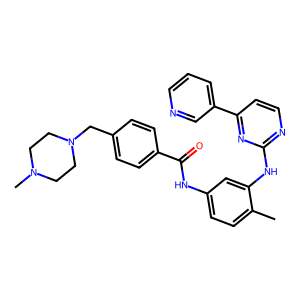

In [9]:
smiles = Chem.MolFromSmiles("CN1CCN(Cc2ccc(cc2)C(=O)Nc2ccc(C)c(Nc3nccc(n3)-c3cccnc3)c2)CC1")
Draw.MolToImage(smiles)

In order to inspect the 3D structure of STI, we use the open source tool `nglview`.
Before we can view STI in `nglview`, we need to compute its 3D coordinates.

First, we add hydrogen atoms to the molecule, which are not always explicitly denoted in the SMILES format.
Second, we use the distance geometry to obtain initial coordinates for the molecule and optimize the structure of the molecule using the force field UFF (Universal Force Field).

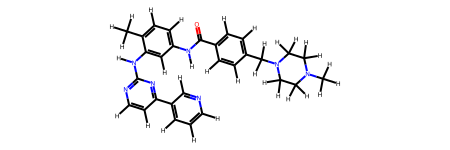

In [10]:
molecule = Chem.AddHs(smiles)
molecule

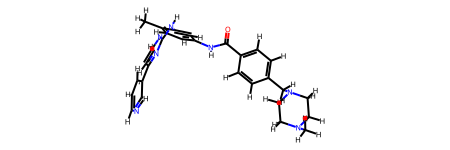

In [11]:
AllChem.EmbedMolecule(molecule)
AllChem.UFFOptimizeMolecule(molecule)
molecule

Now, we are ready to roll in `nglview`!

In [12]:
view = nv.show_rdkit(molecule)
view

NGLWidget()

In [13]:
view.render_image(trim=True, factor=2, transparent=True);

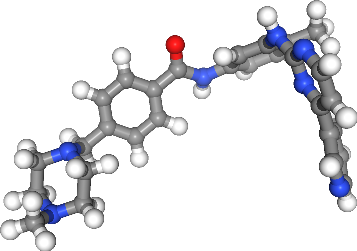

In [14]:
view._display_image()

In [15]:
del view
gc.collect()
output.enable_custom_widget_manager()
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


### Get protein-STI complexes from the PDB

In the following, we will search for PDB IDs describing structures in the PDB that fulfill the following criteria:

- Structure is bound to Imatinib (Ligand Expo ID: STI)
- Structure was experimentally resolved by X-ray crystallography
- Structure has a resolution less or equal to $3.0$
- Structure has only one chain (for simplicity)

Each structure in the PDB database is linked to many different fields to hold meta information such as our defined criteria. Check out the complete list of available fields for [chemicals](https://search.rcsb.org/chemical-search-attributes.html)/[structures](https://search.rcsb.org/structure-search-attributes.html) and supported operators on the RCSB website.

The package `biotite` provides a very nice module `databases.rcsb` (see [docs](https://www.biotite-python.org/apidoc/biotite.database.rcsb.html)), which allows us to query one (`FieldQuery`, see [docs](https://www.biotite-python.org/apidoc/biotite.database.rcsb.FieldQuery.html#biotite.database.rcsb.FieldQuery)) or more (`CompositeQuery`, see [docs](https://www.biotite-python.org/apidoc/biotite.database.rcsb.CompositeQuery.html#biotite.database.rcsb.CompositeQuery)) of these fields to retrieve a count (`count`) or list (`search`) of PDB IDs that match our criteria.

This is a table summarizing our queries:

| Field | Operator | Value |
|-|-|-|
| `rcsb_nonpolymer_entity_container_identifiers.nonpolymer_comp_id` | `exact_match` | STI |
| `exptl.method` | `exact_match` | X-RAY DIFFRACTION |
| `rcsb_entry_info.resolution_combined` | `less_or_equal` | $3.0$ |
| `rcsb_entry_info.deposited_polymer_entity_instance_count` | `equals` | $1$ |

We will first perform each of the queries alone and check the number of matches per condition. Afterwards, we will combine all queries with the `and` operator to match only PDB IDs that fulfill all the conditions.

**Query STI-bound structures**

In [16]:
query_by_ligand_id = rcsb.FieldQuery(
    "rcsb_nonpolymer_entity_container_identifiers.nonpolymer_comp_id", exact_match="STI"
)
print(f"Number of matches: {rcsb.count(query_by_ligand_id)}")

Number of matches: 28


**Query structures from X-ray crystallography**

In [17]:
query_by_experimental_method = rcsb.FieldQuery("exptl.method", exact_match="X-RAY DIFFRACTION")
print(f"Number of matches: {rcsb.count(query_by_experimental_method)}")

Number of matches: 187999


**Query structures with resolution less than or equal to 3.0**

In [18]:
query_by_resolution = rcsb.FieldQuery("rcsb_entry_info.resolution_combined", less_or_equal=3.0)
print(f"Number of matches: {rcsb.count(query_by_resolution)}")

Number of matches: 182207


**Query structures with only one chain**

In [19]:
query_by_polymer_count = rcsb.FieldQuery(
    "rcsb_entry_info.deposited_polymer_entity_instance_count", equals=1
)
print(f"Number of matches: {rcsb.count(query_by_polymer_count)}")

Number of matches: 79777


**Query structures fulfilling all the above criteria**

Use the `and` operator to combine the list of queries above.

In [20]:
query = rcsb.CompositeQuery(
    [
        query_by_ligand_id,
        query_by_experimental_method,
        query_by_resolution,
        query_by_polymer_count,
    ],
    "and",
)
pdb_ids = rcsb.search(query)
print(f"Number of matches: {len(pdb_ids)}")
print("Selected PDB IDs:")
print(*pdb_ids)

Number of matches: 9
Selected PDB IDs:
1T46 1XBB 2PL0 3FW1 3GVU 3HEC 4CSV 4R7I 6JOL


__Note__: The next step has technical reasons only. In order to maintain the notebooks automatically, we define here a certain set of PDB IDs to work with. Thus, even if new PDB structures matching our filtering criteria are added to the PDB, they will not be included in the downstream analysis and therefore the output will stay the same. Remote this step if you want to work with the full set of PDB structures.

In [21]:
pdb_ids = FROZEN_PDB_IDS
print("Final set of PDB IDs:")
print(*pdb_ids)

Final set of PDB IDs:
3HEC 2PL0 4CSV 4R7I 1XBB 3FW1 1T46


### Visualize the PDB structures

First, we load all structures in `nglview` for visual inspection of the 3D structure of the protein data set.

In [22]:
view = nv.NGLWidget()
for pdb_id in pdb_ids:
    view.add_pdbid(pdb_id)
view

NGLWidget()

In [23]:
view.render_image(trim=True, factor=2, transparent=True);

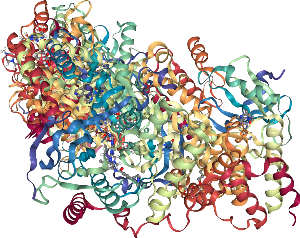

In [24]:
view._display_image()

In [25]:
del view
gc.collect()
output.enable_custom_widget_manager()
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


Though this image is beautifully colorful and curly, it is not informative yet. We align the structures to each other in the next step.

### Align the PDB structures (full protein)

We will use one of our `opencadd` packages (`structure.superposition` module) to guide the structural alignment of the different proteins. The approach we will use is based on superposition guided by sequence alignment provided matched residues. There are other methods in the package, but this simple one will be enough to showcase some similarities.

Note: This approach biases the analysis towards structures with similar sequences. For an automated workflow (where we do not know the sequence or structural similarity of protein pairs) a solution could be to calculate the RMSD based on all three measures and retain the best for further analysis.

First, we show the alignment of all structures to the first structure in the our list.

In [26]:
import requests
import MDAnalysis as mda
def ensure_correct_extension(pdb_file_path):
    """
    파일이 .pdb 확장자로 저장되었는지 확인하는 함수
    :param pdb_file_path: str, PDB 파일 경로
    :return: str, 올바른 확장자의 파일 경로
    """
    if not pdb_file_path.endswith(".pdb"):
        # 확장자가 .pdb가 아니면 수정
        new_pdb_file_path = pdb_file_path + ".pdb"
        os.rename(pdb_file_path, new_pdb_file_path)
        return new_pdb_file_path
    return pdb_file_path

def download_pdb(pdb_id, ):
    """
    PDB ID를 이용하여 PDB 파일을 다운로드하는 함수
    :param pdb_id: str, PDB ID (예: '1tqn')
    :param save_dir: str, 파일을 저장할 디렉터리 경로
    :return: str, 다운로드된 PDB 파일 경로
    """
    # PDB 파일 URL 설정 (RCSB PDB 서버 사용)
    pdb_url = f"https://files.rcsb.org/download/{pdb_id}.pdb"

    # PDB 파일 저장 경로
    pdb_file_path = f"{pdb_id}.pdb"

    # PDB 파일 다운로드
    response = requests.get(pdb_url)

    # 요청이 성공적인 경우 파일로 저장
    if response.status_code == 200:
        with open(pdb_file_path, 'wb') as file:
            file.write(response.content)
        print(f"PDB 파일이 성공적으로 다운로드되었습니다: {pdb_file_path}")
    else:
        raise Exception(f"PDB 파일을 다운로드할 수 없습니다. PDB ID: {pdb_id}")

    return pdb_file_path

def get_structure_from_pdb_id(pdb_id):
    """
    PDB ID로부터 구조 객체를 생성하는 함수
    :param pdb_id: str, PDB ID (예: '1tqn')
    :return: Structure 객체
    """
    # PDB 파일 다운로드
    pdb_file_path = download_pdb(pdb_id)
    print(pdb_file_path)

    # MDAnalysis의 Universe 객체를 사용하여 PDB 파일 로드
    universe = mda.Universe(pdb_file_path, format='pdb')

    # MDAnalysis Universe 객체를 opencadd Structure 객체로 변환
    structure = universe

    return structure

In [27]:
# Download PDB
structures = [get_structure_from_pdb_id(pdb_id) for pdb_id in pdb_ids]
# Strip solvent and other artifacts of crystallography
proteins = [Structure.from_atomgroup(s.select_atoms("protein")) for s in structures]
# Align proteins
results = align(proteins, method=METHODS["mda"])

PDB 파일이 성공적으로 다운로드되었습니다: 3HEC.pdb
3HEC.pdb
PDB 파일이 성공적으로 다운로드되었습니다: 2PL0.pdb
2PL0.pdb
PDB 파일이 성공적으로 다운로드되었습니다: 4CSV.pdb
4CSV.pdb
PDB 파일이 성공적으로 다운로드되었습니다: 4R7I.pdb
4R7I.pdb
PDB 파일이 성공적으로 다운로드되었습니다: 1XBB.pdb
1XBB.pdb
PDB 파일이 성공적으로 다운로드되었습니다: 3FW1.pdb
3FW1.pdb
PDB 파일이 성공적으로 다운로드되었습니다: 1T46.pdb
1T46.pdb


In [28]:
view = nv.NGLWidget()
for protein in proteins:
    view.add_component(protein.atoms)
view

NGLWidget()

In [29]:
view.render_image(trim=True, factor=2, transparent=True);

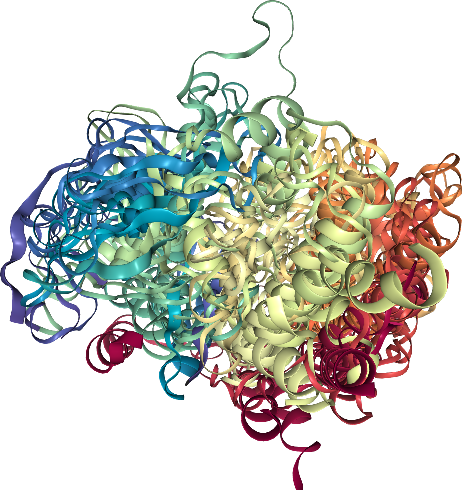

In [30]:
view._display_image()

In [31]:
del view
gc.collect()
output.enable_custom_widget_manager()
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


The structural alignment for many helices is high, whereas lower or poor for other protein parts.

In [32]:
def calc_rmsd(A, B):
    """
    Calculate RMSD between two structures.

    Parameters
    ----------
    A : opencadd.structure.core.Structure
        Structure A.
    B : opencadd.structure.core.Structure
        Structure B.

    Returns
    -------
    float
        RMSD value.
    """
    aligner = MDAnalysisAligner()
    selection, _ = aligner.matching_selection(A, B)
    A = A.select_atoms(selection["reference"])
    B = B.select_atoms(selection["mobile"])
    return rms.rmsd(A.positions, B.positions, superposition=False)

In [33]:
def calc_rmsd_matrix(structures, names):
    """
    Calculate RMSD matrix between a list of structures.

    Parameters
    ----------
    structures : list of opencadd.structure.core.Structure
        List of structures.
    names : list of str
        List of structure names.

    Returns
    -------
    pandas.DataFrame
        RMSD matrix.
    """
    values = {name: {} for name in names}
    for i, (A, name_i) in enumerate(zip(structures, names)):
        for j, (B, name_j) in enumerate(zip(structures, names)):
            if i == j:
                values[name_i][name_j] = 0.0
                continue
            if i < j:
                rmsd = calc_rmsd(A, B)
                values[name_i][name_j] = rmsd
                values[name_j][name_i] = rmsd
                continue
    df = pd.DataFrame.from_dict(values)
    return df

### Get pairwise RMSD (full protein)

In [34]:
# NBVAL_CHECK_OUTPUT
rmsd_matrix = calc_rmsd_matrix(proteins, pdb_ids)
rmsd_matrix.round(1)

,3HEC,2PL0,4CSV,4R7I,1XBB,3FW1,1T46
3HEC,0.0,16.1,12.6,20.5,17.3,23.7,20.4
2PL0,16.1,0.0,3.7,13.5,7.6,22.8,16.4
4CSV,12.6,3.7,0.0,14.0,7.8,22.5,16.7
4R7I,20.5,13.5,14.0,0.0,11.8,21.9,8.0
1XBB,17.3,7.6,7.8,11.8,0.0,22.3,14.3
3FW1,23.7,22.8,22.5,21.9,22.3,0.0,21.4
1T46,20.4,16.4,16.7,8.0,14.3,21.4,0.0


We visualize the results of this RMSD refinement as heatmap.

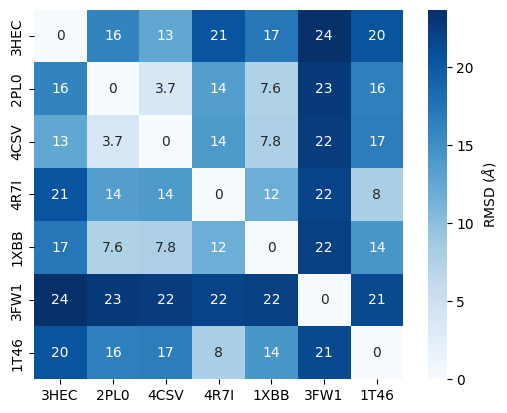

In [35]:
# Make sure matplotlib version >= 3.1.2; otherwise you'll get Y-cropped heatmaps
sns.heatmap(
    rmsd_matrix,
    linewidths=0,
    annot=True,
    square=True,
    cbar_kws={"label": "RMSD ($\AA$)"},
    cmap="Blues",
);

We cluster the heatmap in order to see protein similarity based on the RMSD refinement.

In [36]:
def plot_clustermap(rmsd):
    """
    Plot clustered heatmap from import RMSD matrix.

    Parameters
    ----------
    rmsd : pandas.DataFrame
        RMSD matrix.
    title : str
        Plot title.

    Returns
    -------
    matplotlib.figure.Figure
        Clustered heatmap.
    """
    g = sns.clustermap(
        rmsd,
        linewidths=1,
        annot=True,
        cbar_kws={"label": "RMSD ($\AA$)"},
        cmap="Blues",
    )
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    sns.set(font_scale=1.5)
    return plt.gcf()

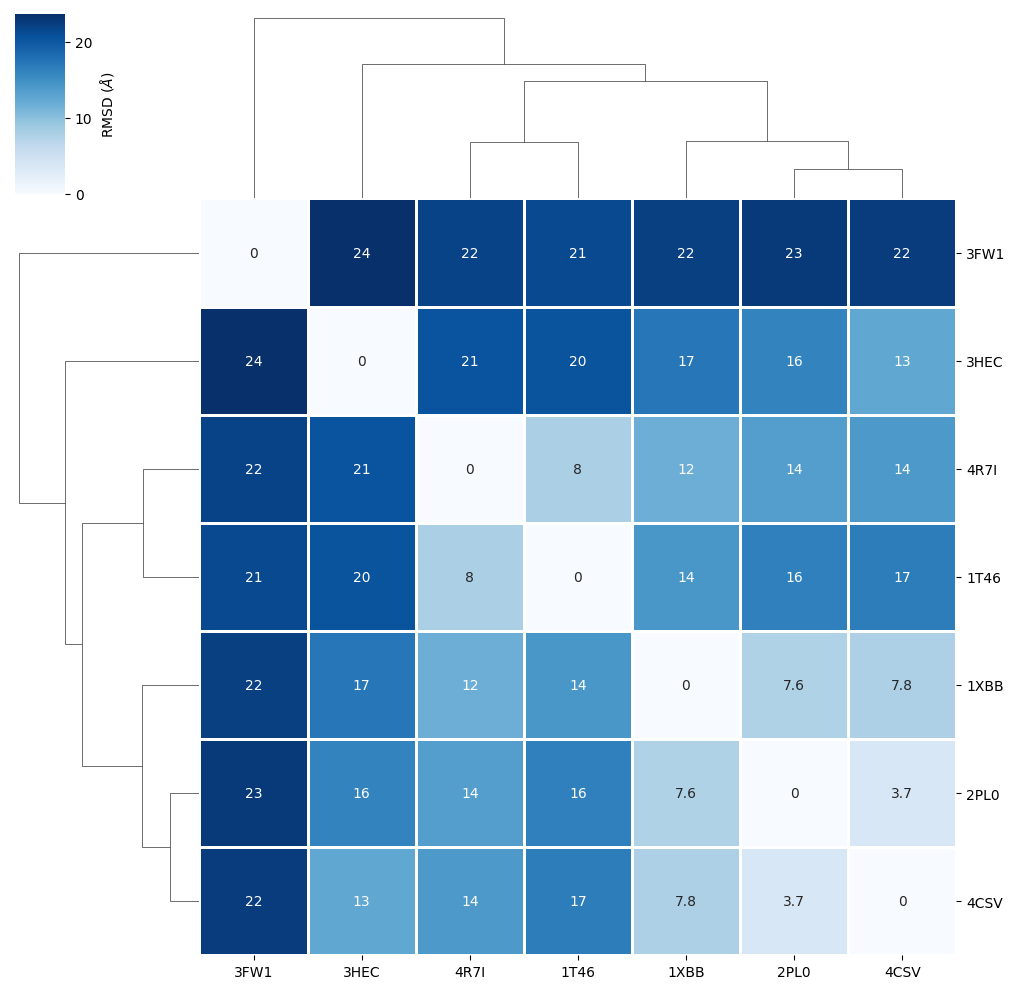

In [37]:
plot_clustermap(rmsd_matrix);

The RMSD comparison shows that one protein differs most from the other proteins, i.e. 3FW1. Let's try to understand by checking which proteins we have in our dataset.

Proteins are classified by the chemical reactions that they catalyze with EC (Enzyme Commission) numbers. We will use them here to check the enzymatic groups the proteins belong to. Let's get the EC numbers from the PDB using the package `pypdb` (see more details in **Talktorial T008**).

In [39]:
# NBVAL_CHECK_OUTPUT
# Get EC numbers for PDB IDs from PDB
pdbs_info = [pypdb.get_all_info(pdb_id) for pdb_id in pdb_ids]
pdbx_descriptors = [
    pdb_info.get("struct", {}).get("pdbx_descriptor", "N/A") for pdb_info in pdbs_info
]
ec_numbers = pd.DataFrame(
    {
        "pdb_id": pdb_ids,
        "description": pdbx_descriptors,
    }
)
# Increase column width to fit all text
pd.set_option("max_colwidth", 100)
ec_numbers

,pdb_id,description
0,3HEC,N/A
1,2PL0,N/A
2,4CSV,N/A
3,4R7I,N/A
4,1XBB,N/A
5,3FW1,N/A
6,1T46,N/A


We can see that 3FW1 is a the human quinone reductase 2 (NQO2), the only protein not belonging to class 2.7 (phosphorus transferases), which contains the tyrosine kinases (EC 2.7.10.2), the designated targets for Imatinib. 3FW1 is a reported off-target "with potential implications for drug design and treatment of chronic myelogenous leukemia in patients" ([<i>BMC Struct. Biol.</i> (2009), <b>9</b>](https://bmcstructbiol.biomedcentral.com/articles/10.1186/1472-6807-9-7)).

### Align PDB structures (binding sites)

So far, we have used the full protein structure for the alignment and RMSD refinement. However, ligands bind only at a protein's binding site.
Therefore, the similarity of binding sites is a more putative basis for off-target prediction rather than of the similarity of full protein structures.

We define a binding site of a protein by selecting all residues that are within 10 &#8491; of any ligand atom. These binding site residues are used for alignment and only their C&#593; atoms (protein backbone) are used for the RMSD refinement. Here, we show the alignment of all structures to the first structure in our list.

Note that for the aligner to work, full residues must be selected as part of the distance search, hence the need for the `same residue as (...)` query.

In [40]:
sel = "same residue as (resname STI or (around 10 resname STI))"
binding_sites = [Structure.from_atomgroup(s.select_atoms(sel)) for s in structures]

Let's look at the proteins' binding sites only.

In [42]:
view = nv.NGLWidget()
for binding_site in binding_sites:
    view.add_component(binding_site.atoms)
view

NGLWidget()

In [ ]:
view.render_image(trim=True, factor=2, transparent=True);

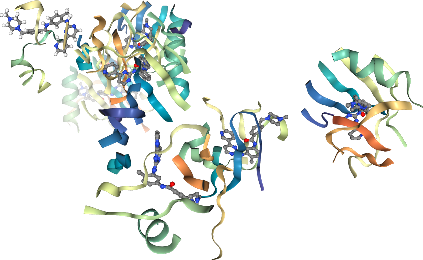

In [ ]:
view._display_image()

In [ ]:
del view
gc.collect()
output.enable_custom_widget_manager()
!jupyter nbextension enable --py widgetsnbextension

Now we align the binding sites.

In [ ]:
results_binding_sites = align(binding_sites, method=METHODS["mda"])

Let's visualize our aligned binding sites.

In [ ]:
view = nv.NGLWidget()
for binding_site in binding_sites:
    view.add_component(binding_site.atoms)
view

NGLWidget()

In [ ]:
view.render_image(trim=True, factor=2, transparent=True);

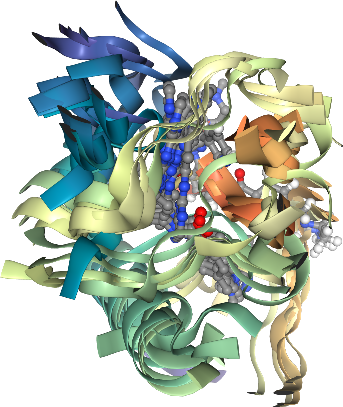

In [ ]:
view._display_image()

### Get pairwise RMSD (binding sites)

In [ ]:
# NBVAL_CHECK_OUTPUT
rmsd_matrix_binding_sites = calc_rmsd_matrix(binding_sites, pdb_ids)
rmsd_matrix_binding_sites.round(1)

,3HEC,2PL0,4CSV,4R7I,1XBB,3FW1,1T46
3HEC,0.0,6.2,3.3,5.7,12.3,15.0,9.8
2PL0,6.2,0.0,4.5,4.0,11.7,11.3,4.3
4CSV,3.3,4.5,0.0,5.6,10.7,14.3,6.3
4R7I,5.7,4.0,5.6,0.0,10.5,14.5,2.7
1XBB,12.3,11.7,10.7,10.5,0.0,13.5,11.1
3FW1,15.0,11.3,14.3,14.5,13.5,0.0,15.3
1T46,9.8,4.3,6.3,2.7,11.1,15.3,0.0


We show the clustered heatmap for the RMSD results.

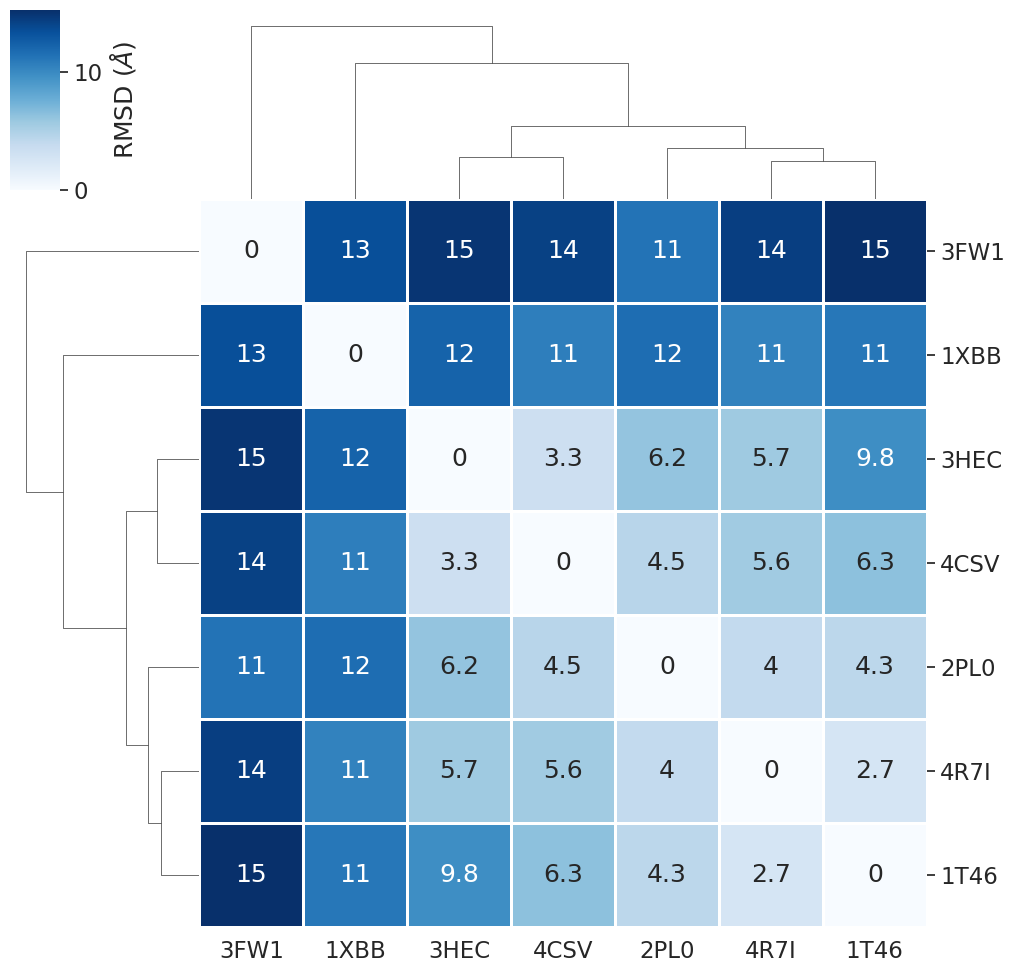

In [ ]:
# Show the pairwise RMSD values as clustered heatmap
plot_clustermap(rmsd_matrix_binding_sites);

What are the key observations in this heatmap?

- As observed already during the *full protein* comparison, also the *binding site* comparison reveals the highest dissimilarity for `3FW1`. Since `3FW1` is the only structure in our dataset representing not a kinase, we are content that our similarity measure was able to spot this. As discussed before, the human quinone reductase 2 (`3FW1`) is a reported off-target for Imatinib.
- Also the kinase `1XBB` shows a higher dissimilarity compared to the other kinases. This can be explained by `1XBB` being resolved in a different conformation (DFG-in) than the other kinases (DFG-out). The DFG motif is an important structural element in kinases, defining whether a kinase is active (DFG-in conformation) or inactive (DFG-out conformation). Note: DFG conformations of kinase structures can be looked up e.g. in the [KLIFS database](https://www.klifs.net).
- The remaining structures are comparatively similar to each other, which we would expect since they all represent kinases in the overall same conformation.

Note that RMSD values as calculated here are dependent on the residue selection (binding site definition) and the quality of the a priori sequence alignment.

### Filter out outliers

For a cleaner depiction of the most similar structures, we can filter `3FW1` and `1XBB` out and re-run the binding site comparison.

In [ ]:
filtered_structures = []
filtered_pdb_ids = []
for name, structure in zip(pdb_ids, structures):
    if name not in ("3FW1", "1XBB"):
        filtered_structures.append(structure)
        filtered_pdb_ids.append(name)

In [ ]:
selection = "same residue as (resname STI or (around 10 resname STI))"
filtered_binding_sites = [
    Structure.from_atomgroup(s.select_atoms(selection)) for s in filtered_structures
]

In [ ]:
view = nv.NGLWidget()
for binding_site in filtered_binding_sites:
    view.add_component(binding_site.atoms)
view

NGLWidget()

In [ ]:
view.render_image(trim=True, factor=2, transparent=True);

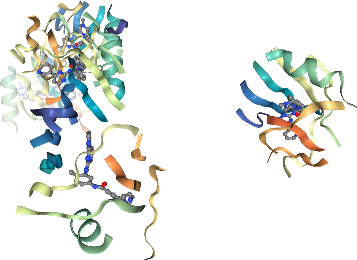

In [ ]:
view._display_image()

In [ ]:
filtered_results_binding_sites = align(filtered_binding_sites, method=METHODS["mda"])

In [ ]:
view = nv.NGLWidget()
for binding_site in filtered_binding_sites:
    view.add_component(binding_site.atoms)
view

NGLWidget()

In [ ]:
view.render_image(trim=True, factor=2, transparent=True);

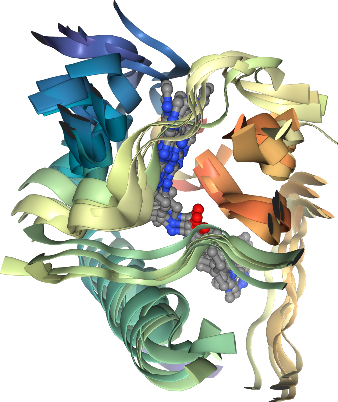

In [ ]:
view._display_image()

In [ ]:
# NBVAL_CHECK_OUTPUT
filtered_rmsd_matrix_bs = calc_rmsd_matrix(filtered_binding_sites, filtered_pdb_ids)
filtered_rmsd_matrix_bs.round(1)

,3HEC,2PL0,4CSV,4R7I,1T46
3HEC,0.0,6.2,3.3,5.7,9.8
2PL0,6.2,0.0,4.5,4.0,4.3
4CSV,3.3,4.5,0.0,5.6,6.3
4R7I,5.7,4.0,5.6,0.0,2.7
1T46,9.8,4.3,6.3,2.7,0.0


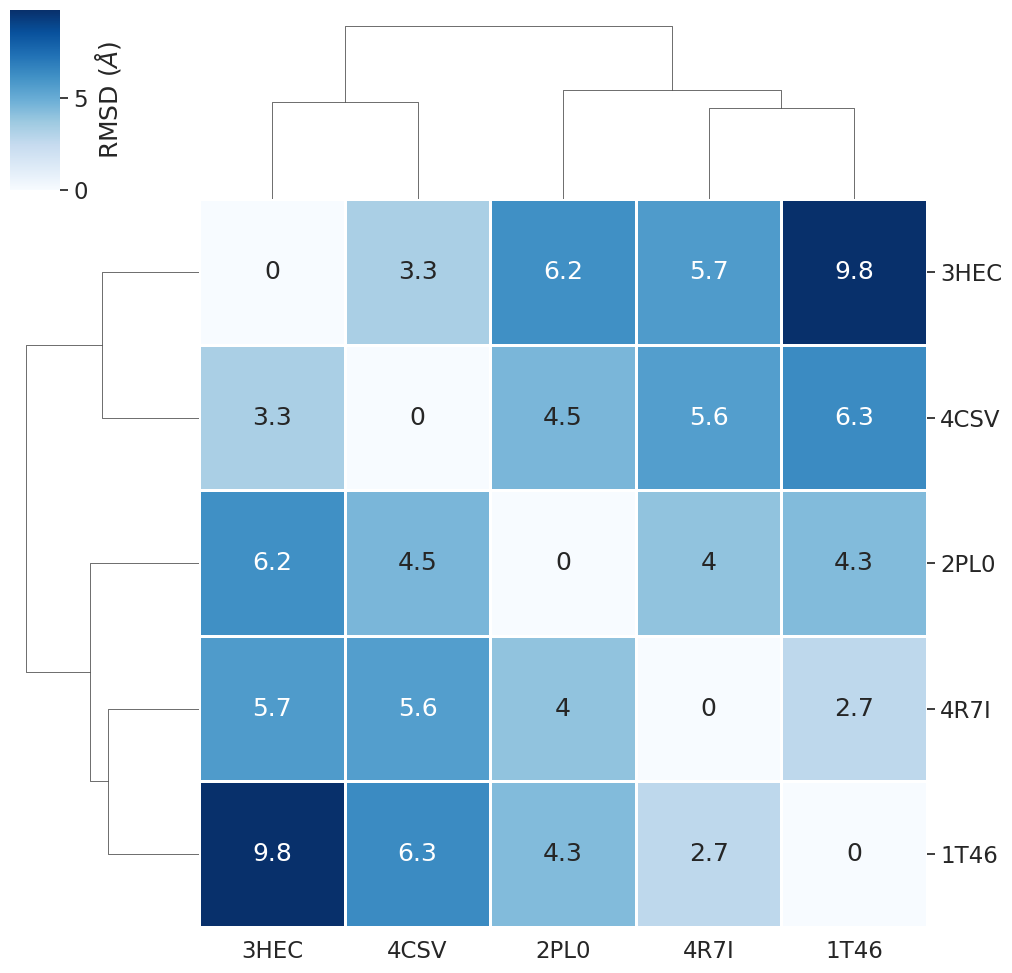

In [ ]:
plot_clustermap(filtered_rmsd_matrix_bs);

Much better!

## Discussion

In this talktorial, we have used a simple comparison approach, i.e. sequence alignment and subsequent RMSD refinement of (i) full proteins and (ii) binding sites, to assess the similarity and dissimilarity of a small set of structures showing Imatinib-binding proteins.
In our data set, we were able to spot an off-target for Imatinib (highest dissimilarity) and a kinase resolved in a different conformation compared to the rest of the kinases (also with a relatively high dissimilarity).
Given our simple approach, we are content with these results!

In a real case scenario, off-targets for Imatinib would be predicted by comparing the binding site of an intended target of Imatinib (a tyrosine kinase) with a large database of resolved structures (PDB).
Since this results in the comparison of sequences also with low similarity, more sophisticated methods should be invoked
that use a sequence-independent alignment algorithm and that include the physico-chemical properties of the binding site.

## Quiz

1. Explain the terms on- and off-targets of a drug.
2. Explain why binding site similarity can be used to find off-targets based on a query target.
3. Discuss how useful the RMSD value of (i) full proteins and (ii) protein binding sites is for off-target prediction.
4. Think of alternate approaches to encode binding site information.